In [14]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt 
from genetic_algorithm import solve_singleplayer_lp_genetic, solve_multiplayer_lp_genetic
from simulated_annealing import solve_singleplayer_sim_anneal, solve_multiplayer_sim_anneal
import solve_lp
import instance_gen
import singleplayer_lp, multiplayer_lp
import converters

Generate a random singleplayer game instance

In [15]:
T1_CONVERTERS = 4
T2_CONVERTERS = 3
T3_CONVERTERS = 2
ADDITIONAL_RESOURCES = 10

In [16]:
convs = instance_gen.gen_converters(T1_CONVERTERS,T2_CONVERTERS,T3_CONVERTERS)
ress = instance_gen.gen_resources(ADDITIONAL_RESOURCES)
inst = singleplayer_lp.gen_instance(convs,ress)

Run the GLPK MIP solver on the singleplayer problem

In [17]:
solution = solve_lp.cvxpy_solve(inst)
if solution is not None:
    for i,x in enumerate(solution):
        if x:
            print("Used:", convs[i])
    print("Score:",np.dot(solution, inst[0]))

Used: Converter(name='Achronal Analysis', inputs='BBB', output=6.5)
Used: Converter(name='Atomic Transmutation', inputs='O', output=4)
Used: Converter(name='Temporal Dilation', inputs='UUUU', output=18)
Used: Converter(name='Ubiquitous Cultural Repository', inputs='YY', output=7)
Score: 35.5


Run the Genetic Algorithm solver on the singleplayer problem

In [18]:
# hyperparameters
GA_MAX_ITERS = 100
MAX_POPULATION_SIZE = 100
KEEP_TOP_K = 20
MUTATION_RATE = 1 / len(convs)

In [19]:

print("Genetic Algorithm Solver")
solution, statistics = solve_singleplayer_lp_genetic(
    inst, 
    max_population_size=MAX_POPULATION_SIZE, 
    keep_top_k=KEEP_TOP_K,
    max_iters=GA_MAX_ITERS,
    mutation_rate=MUTATION_RATE
)
if solution is not None:
    for i,x in enumerate(solution):
        if x:
            print("Used:", convs[i])
    print("Score:",np.dot(solution, inst[0]))
    
    print("\nStatistics")
    for k,v in statistics.items():
        if type(v) is not list:
            print(f"  {k}: {v}")
else:
    print("found no solution...")

Genetic Algorithm Solver
Used: Converter(name='Achronal Analysis', inputs='BBB', output=6.5)
Used: Converter(name='Atomic Transmutation', inputs='O', output=4)
Used: Converter(name='Temporal Dilation', inputs='UUUU', output=18)
Used: Converter(name='Ubiquitous Cultural Repository', inputs='YY', output=7)
Score: 35.5

Statistics
  elapsed_time: 0.5909981727600098
  iterations: 100
  convergence: 0.0


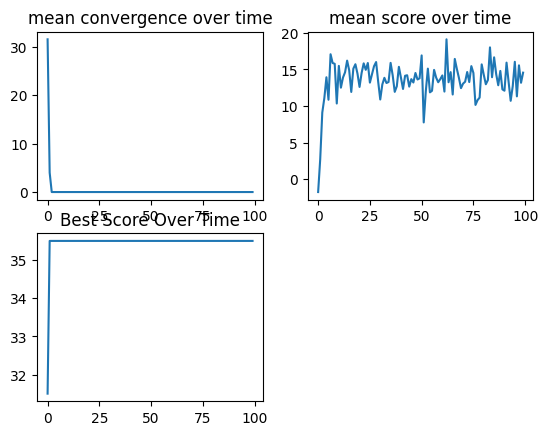

In [20]:
plt.subplot(2, 2, 1)
# plot convergence over time
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["mean_convergence_over_time"])
plt.title("mean convergence over time")

# plot mean score over time
plt.subplot(2, 2, 2)
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["mean_score_over_time"])
plt.title("mean score over time")

# plot best score over time
plt.subplot(2, 2, 3)
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["best_score_over_time"])
plt.title("Best Score Over Time")

plt.show()

Run the Simulated Annealing Solver on the singleplayer problem

In [21]:
solution_SA, best_score_over_time_SA = solve_singleplayer_sim_anneal(inst, init_temp=8000, max_iter=2000, return_stats=False)

print("Simulated Annealing")
for i,x in enumerate(solution_SA):
    if x:
        print("Used:", convs[i])
print("Score:",np.dot(solution_SA, inst[0]))

Simulated Annealing
Used: Converter(name='Achronal Analysis', inputs='BBB', output=6.5)
Used: Converter(name='Atomic Transmutation', inputs='O', output=4)
Used: Converter(name='Temporal Dilation', inputs='UUUU', output=18)
Used: Converter(name='Ubiquitous Cultural Repository', inputs='YY', output=7)
Score: 35.5


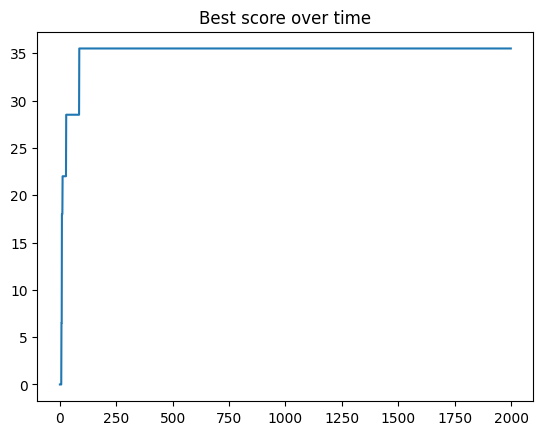

In [22]:
plt.plot(list(range(len(best_score_over_time_SA))), best_score_over_time_SA)
plt.title("Best score over time")
plt.show()

Generate a multiplayer game instance

In [23]:
NUMBER_OF_PLAYERS = 5
MAX_TRADE_BETWEEN_PLAYERS = 20

In [24]:
players = [(instance_gen.gen_converters(T1_CONVERTERS,T2_CONVERTERS,T3_CONVERTERS),instance_gen.gen_resources(ADDITIONAL_RESOURCES)) for p in range(NUMBER_OF_PLAYERS)]
inst0 = multiplayer_lp.gen_instance(players)[1]
mp_singleplayer_solution = solve_lp.cvxpy_solve(inst0)
mp_vars, multiplayer_inst = multiplayer_lp.gen_instance(players, MAX_TRADE_BETWEEN_PLAYERS)

Solve each player as a singleplayer problem, to get a baseline to compare with the multiplayer solutions

In [25]:
mp_sp_solutions = []
for i,p in enumerate(players):
    p1s = solve_lp.cvxpy_solve(singleplayer_lp.gen_instance(*p))
    mp_sp_solutions.append(multiplayer_lp.singleplayer_opt(p))

Run the Genetic Algorithm solver on the multiplayer instance

In [26]:
# hyperparameters
import math
GA_MAX_ITERS = 100
MAX_POPOLUATION_SIZE = 100
KEEP_TOP_K = math.ceil(MAX_POPOLUATION_SIZE * (1/5))
MUTATION_RATE = 0.005

In [29]:

multiplayer_soln_GA, statistics = solve_multiplayer_lp_genetic(
    multiplayer_inst,
    max_population_size=MAX_POPOLUATION_SIZE,
    keep_top_k=KEEP_TOP_K,
    max_iters=GA_MAX_ITERS,
    mutation_rate=MUTATION_RATE,
    starting_solution=mp_singleplayer_solution
)

if multiplayer_soln_GA is not None:
    scores = [0] * NUMBER_OF_PLAYERS
    for x,v in zip(multiplayer_soln_GA, mp_vars):
        if len(v) == 2 and x > 0:
            scores[v[0]] += v[1].output*x
    # print singleplayer solutions for each player
    print(mp_sp_solutions, sum(mp_sp_solutions))
    # print multiplayer solution
    print(scores, sum(scores))
else:
    print("failed to find solution...")

[39.0, 40.0, 29.5, 25.0, 39.5] 173.0
[39.0, 40.0, 29.5, 52.0, 45.5] 206.0


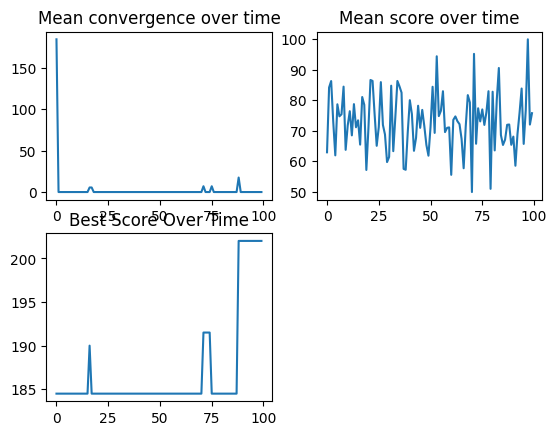

In [ ]:
plt.subplot(2, 2, 1)
# plot convergence over time
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["mean_convergence_over_time"])
plt.title("Mean convergence over time")

# plot mean score over time
plt.subplot(2, 2, 2)
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["mean_score_over_time"])
plt.title("Mean score over time")

# plot best score over time
plt.subplot(2, 2, 3)
plt.plot([i for i in range(GA_MAX_ITERS)], statistics["best_score_over_time"])
plt.title("Best Score Over Time")

plt.show()

Run the Simulated Annealing solver on the multiplayer instance

In [ ]:
# hyperparameters
TEMPERATURE = 8000
SA_MAX_ITERS = 2000

In [ ]:
multiplayer_solution_SA, multiplayer_best_score_over_time_SA = solve_multiplayer_sim_anneal(
    multiplayer_inst, mp_singleplayer_solution, init_temp=TEMPERATURE, max_iter=SA_MAX_ITERS, return_stats=False
)

if multiplayer_solution_SA is not None:
    scores = [0] * NUMBER_OF_PLAYERS
    for x,v in zip(multiplayer_solution_SA,mp_vars):
        if len(v) == 2 and x > 0:
            scores[v[0]] += v[1].output*x
    # print singleplayer solutions for each player
    print(mp_sp_solutions, sum(mp_sp_solutions))
    # print multiplayer solution
    print(scores, sum(scores))

[46.5, 32.0, 29.0, 31.5, 45.5] 184.5
[46.5, 39.0, 29.0, 31.5, 52.5] 198.5


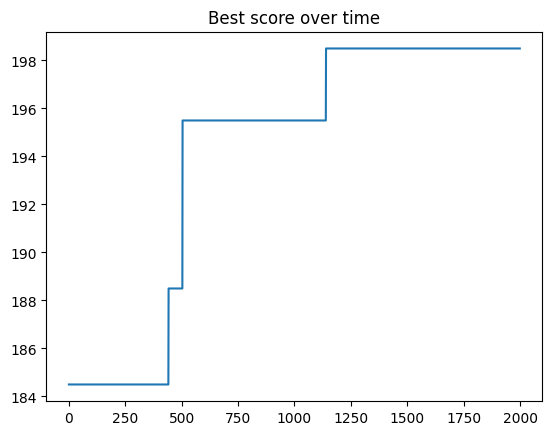

In [ ]:
plt.plot(list(range(len(multiplayer_best_score_over_time_SA))), multiplayer_best_score_over_time_SA)
plt.title("Best score over time")
plt.show()

Dual LP example

In [ ]:
print('==== dual values ====')
dual = solve_lp.cvxpy_dual(inst)
print("Score upper-bound", dual @ inst[2][:-9])
print('\n'.join([f'{res}: {v}' for res, v in zip(list(converters.resource_types) + convs, dual)]))

==== dual values ====
Score upper-bound 27.999999999984666
O: 2.816309922847554e-11
U: 3.765482522179891e-11
R: 0.7920638340612091
B: 5.664713278657476
G: 3.7542259420272526
Y: -6.467465007763916e-13
W: -3.738561986769806e-11
Converter(name='Achronal Analysis', inputs='BBB', output=6.5): 4.474412324525193e-11
Converter(name='Clinical Immortality', inputs='UU', output=7): 6.9999999999116715
Converter(name='Cross Species Ethical Equality', inputs='WWWW', output=10): 10.000000000064638
Converter(name='Galactic Telecom Control', inputs='BBBB', output=21): 4.096349762927794e-11
Converter(name='Genetic Engineering', inputs='GGG', output=4): 3.0532133478245406e-11
Converter(name='Interspecies Medical Exchange', inputs='GGGG', output=9): 3.2139977928622855e-11
Converter(name='Nanotechnology', inputs='RRR', output=4): 1.6238084977284486
Converter(name='Poly Species Corporations', inputs='GGGGG', output=15): 3.2083401585274246e-11
Converter(name='Universal Translator', inputs='WWW', output=7): 7

In [28]:
print('==== dual values ====')
dual = solve_lp.cvxpy_dual(multiplayer_inst)
print("Score upper-bound", dual @ multiplayer_inst[2][:-9])
print('\n'.join([f'{res}: {v}' for res, v in zip(list(converters.resource_types) + convs, dual)]))

==== dual values ====
Score upper-bound 321.416666675403
O: 10.666666672125357
U: 10.666666667761685
R: 10.666666667575113
B: 10.666666666899856
G: 10.666666666697676
Y: 1.6805703468403986e-09
W: 1.2809973688411771e-09
Converter(name='Achronal Analysis', inputs='BBB', output=6.5): 1.1882445465343126e-09
Converter(name='Atomic Transmutation', inputs='O', output=4): 1.0416933706187115e-09
Converter(name='Hyperspace Mining', inputs='YYY', output=7.5): 9.830938405933545e-10
Converter(name='Nanotechnology', inputs='RRR', output=4): 1.7617928965135053e-10
Converter(name='Singularity Control', inputs='OO', output=8.5): 1.3873013793937535e-10
Converter(name='Social Exodus', inputs='WWWWW', output=20.5): 1.0476112550394365e-10
Converter(name='Temporal Dilation', inputs='UUUU', output=18): 6.882753833791954e-11
Converter(name='Ubiquitous Cultural Repository', inputs='YY', output=7): 5.107210326908842e-11
Converter(name='Universal Translator', inputs='WWW', output=7): 2.166666666396175
